In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# This function will generate a dataframe out of a time series list
def time_to_df(list1, number_of_attributes = 3):
    df = pd.DataFrame(columns=range(number_of_attributes))
    
    for i in range(len(list1)-number_of_attributes+1):
        record = []
        for j in range(i,i+number_of_attributes):
            record.append(list1[j])
        df.loc[len(df.index)] = record
        
        
    return df


def forecasted_series_to_df(series, forecasted_series_, npast_year, name_of_forecasted_column, name_of_datetime_index_column):
    
    forecasted_series = forecasted_series_.copy()
    y = 0
    index_for_forcaste = []
    index_for_forcaste.append(series.index[-npast_year-1]+ pd.DateOffset(months=12))
    for i in range(1,len(forecasted_series)):
        y = y+1
        date_temp = index_for_forcaste[-1]
        date_temp = date_temp + pd.DateOffset(months=12)
        index_for_forcaste.append(date_temp)

    forecasted_series.index = pd.to_datetime(index_for_forcaste)
    forecasted_series = pd.DataFrame({name_of_datetime_index_column:forecasted_series.index, name_of_forecasted_column:forecasted_series.values})
    forecasted_series.index = forecasted_series[name_of_datetime_index_column]
    forecasted_series = forecasted_series.drop(name_of_datetime_index_column, axis = 1)

    return forecasted_series

# This function trains the model using the input data(dataframe)
def train_and_forecast(list1, number_of_forecast = 5, npast_year =0, number_of_attributes = 3):

    input1 = time_to_df(list1, number_of_attributes)
    # We take last column of the features as target and rest are taken as attributes
    featureMat = input1.iloc[:, : len(input1.columns) - 1]
    label = input1[input1.columns[-1]]
    train_features, test_features, train_res, test_res= train_test_split(featureMat,label,test_size=0.4)
    
    # Here we are using linear regression model
    #model = linear_model.LinearRegression()
    model = linear_model.ElasticNet(alpha = 0.7)
    model.fit(train_features, train_res)
    test_result = model.predict(test_features)
    # Checking for the score
    #print("Score (R2 score): ", model.score(test_features, test_res))
    MSE_Score =int((100*(1/len(test_res))*np.sum(test_result - test_res)*
                             np.sum(test_result - test_res)))/100

    forecasted_values = []
    if(npast_year != 0):
        list_for_forcasting = list1[:-npast_year]
    else:
        list_for_forcasting = list1
    for i in range(number_of_forecast+npast_year):
        
        features_for_forecast = list_for_forcasting[-number_of_attributes+1:]
        forecasted_value = model.predict([features_for_forecast])[0]
        forecasted_values.append(forecasted_value)
        list_for_forcasting.append(forecasted_value)
        
    return forecasted_values, MSE_Score

    

def forecast(series, nforecast_year = 10, npast_year =0, p = 3):

    number_of_forecast = nforecast_year
    
    # Generate predictions
    forecasts, mse = train_and_forecast(series.to_list(), number_of_forecast, npast_year, p+1)
    forecasts_ser = pd.Series(forecasts, copy=False)
    to_plot=forecasted_series_to_df(series, forecasts_ser, npast_year, str(series.name), "Date")

    return to_plot, series, mse

    

In [72]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import dateutil.parser # for handling the conversion of datetime formats
from datetime import timedelta # for operating the datetime objects
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_sarima_model(X, arima_order):

    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()

    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):

    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:

        for d in d_values:

            for q in q_values:

                order = (p,d,q)
                try:
                    rmse = evaluate_sarima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    
                except:
                    continue

    return best_cfg, best_score






In [81]:

def forecast_n_plot(data_to_focus,yaxis_label):

  countries = data_to_focus.columns.to_list()

  forecasted_dict = {}
  past_year = 5
  future_year = 6


  # evaluate parameters
  p_values = [0, 1, 2, 4]
  d_values = range(0, 3)
  q_values = range(0, 3)


  for country in countries:
      
      print("\n"*3)
      print("Forecasting the inflation for country: ", country)
      print("#"*40)


      best_cfg, best_score = evaluate_models(data_to_focus[country].dropna(axis =0).values, p_values, d_values, q_values)
      print("SARIMAX model MSE Score: ",int(100*best_score)/100)
      model = SARIMAX(data_to_focus[country], order=best_cfg)
      results = model.fit()
      one_step_forecast = results.get_prediction(start=len(data_to_focus[country])-past_year-1,
                                                end = len(data_to_focus[country])+future_year-1)
      mean_forecast = one_step_forecast.predicted_mean
      forecasted_1, actual, mse = forecast(data_to_focus[country].dropna(axis =0), nforecast_year = future_year,npast_year = past_year, p = 1)
      print("AR1 model MSE Score: ",mse )
      forecasted_2, actual, mse = forecast(data_to_focus[country].dropna(axis =0), nforecast_year = future_year,npast_year = past_year, p = 2)
      print("AR2 model MSE Score: ",mse )
      forecasted_3, actual, mse = forecast(data_to_focus[country].dropna(axis =0), nforecast_year = future_year,npast_year = past_year, p = 3)
      print("AR3 model MSE Score: ",mse )
      forecasted_4, actual, mse = forecast(data_to_focus[country].dropna(axis =0), nforecast_year = future_year,npast_year = past_year, p = 4)
      print("AR4 model MSE Score: ",mse )
      forecasted_5, actual, mse = forecast(data_to_focus[country].dropna(axis =0), nforecast_year = future_year,npast_year = past_year, p = 5)
      print("AR5 model MSE Score: ",mse )
      print("#"*40)

      forecasted = pd.DataFrame()
      forecasted.index = forecasted_1.index
      forecasted["AR1"] = forecasted_1[country]
      forecasted["AR2"] = forecasted_2[country]
      forecasted["AR3"] = forecasted_3[country]
      forecasted["AR4"] = forecasted_4[country]
      forecasted["AR5"] = forecasted_5[country]

      forecasted["SARIMAX"] = mean_forecast
      confidence_intervals = one_step_forecast.conf_int()
      
      lower_limits = confidence_intervals.loc[:,'lower '+country]
      upper_limits = confidence_intervals.loc[:,'upper '+country]
      print("\n"*2)
      print("TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES\n")
      display(forecasted)
      forecasted["lowest_possible"] = lower_limits
      forecasted["highest_possible"] = upper_limits

    

      plt.figure(figsize =(20,8))
      plt.plot(data_to_focus[country].index, data_to_focus[country] ,label='observed', marker = "o")

      for x, y in zip(data_to_focus[country].index, data_to_focus[country]):
        plt.annotate(str(y), (x,y))

      plt.plot(mean_forecast.index[-future_year:], mean_forecast[-future_year:],color='red' ,label='Sarimax', marker = "*")
      plt.plot(forecasted.index[-future_year:], forecasted_1[-future_year:],color='green' ,label='AR1', marker = "*")
      plt.plot(forecasted.index[-future_year:], forecasted_2[-future_year:],color='blue' ,label='AR2', marker = "*")
      plt.plot(forecasted.index[-future_year:], forecasted_3[-future_year:],color='purple' ,label='AR3', marker = "*")
      plt.plot(forecasted.index[-future_year:], forecasted_4[-future_year:],color='yellow' ,label='AR4', marker = "*")
      
      
      for x, y in zip(mean_forecast.index[-future_year:], mean_forecast[-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))

      for x, y in zip(forecasted.index[-future_year:], forecasted_1[country][-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))

      for x, y in zip(forecasted.index[-future_year:], forecasted_2[country][-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))

      for x, y in zip(forecasted.index[-future_year:], forecasted_3[country][-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))

      for x, y in zip(forecasted.index[-future_year:], forecasted_4[country][-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))

      plt.xlabel('Year')
      plt.ylabel(yaxis_label)
      plt.legend()
      plt.title(country)

      plt.show()



      plt.figure(figsize =(20,8))
      plt.plot(data_to_focus[country].index, data_to_focus[country] ,label='observed', marker = "o")

      for x, y in zip(data_to_focus[country].index, data_to_focus[country]):
        plt.annotate(str(y), (x,y))

      plt.plot(mean_forecast.index[-future_year:], mean_forecast[-future_year:],color='red' ,label='OurForecast', marker = "*")
    

      for x, y in zip(mean_forecast.index[-future_year:], mean_forecast[-future_year:]):
        plt.annotate(str(int(y*10)/10), (x,y))
      

      # Shade uncertainty area
      plt.fill_between(mean_forecast.index[-future_year:], lower_limits[-future_year:], upper_limits[-future_year:], color='pink')


      # set labels, legends and show plot
      plt.xlabel('Year')
      plt.ylabel('Defences in Billon $')
      plt.title(country)
      plt.legend()
      print("\n")
      plt.show()

      forecasted_dict[country]= forecasted

      previous = [str(int(i*10)/10)+"%" for i in data_to_focus[country].to_list()[-past_year-1:]]
      for i in range(future_year-1):
          previous.append(" ")
      
      actual = [str(int(i*10)/10)+"%" for i in data_to_focus[country].to_list()[-past_year:]]   
      for i in range(future_year):
          actual.append(" ")

      to_plot = forecasted_dict[country].copy()
    





Forecasting the inflation for country:  Ukraine (Billion $)
########################################
SARIMAX model MSE Score:  0.9
AR1 model MSE Score:  3.1
AR2 model MSE Score:  0.92
AR3 model MSE Score:  1.52
AR4 model MSE Score:  0.44
AR5 model MSE Score:  0.44
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,3.148217,3.710680,3.805304,3.727413,3.520090,3.336136
2019-01-01,3.092120,4.096599,4.245448,4.099960,3.709790,4.405171
2020-01-01,3.061202,4.514889,4.749712,4.520118,3.845014,5.882771
2021-01-01,3.044162,4.914664,5.266642,4.935283,3.941299,6.640214
2022-01-01,3.034771,5.320118,5.805717,5.358196,4.009863,6.554643
2023-01-01,3.029594,5.719771,6.368632,5.787445,4.058688,9.298747
2024-01-01,3.026742,6.119095,6.955211,6.222685,4.093455,10.137723
2025-01-01,3.025169,6.515506,7.566971,6.664375,4.118213,11.064426
2026-01-01,3.024303,6.910247,8.204856,7.112458,4.135842,12.274378


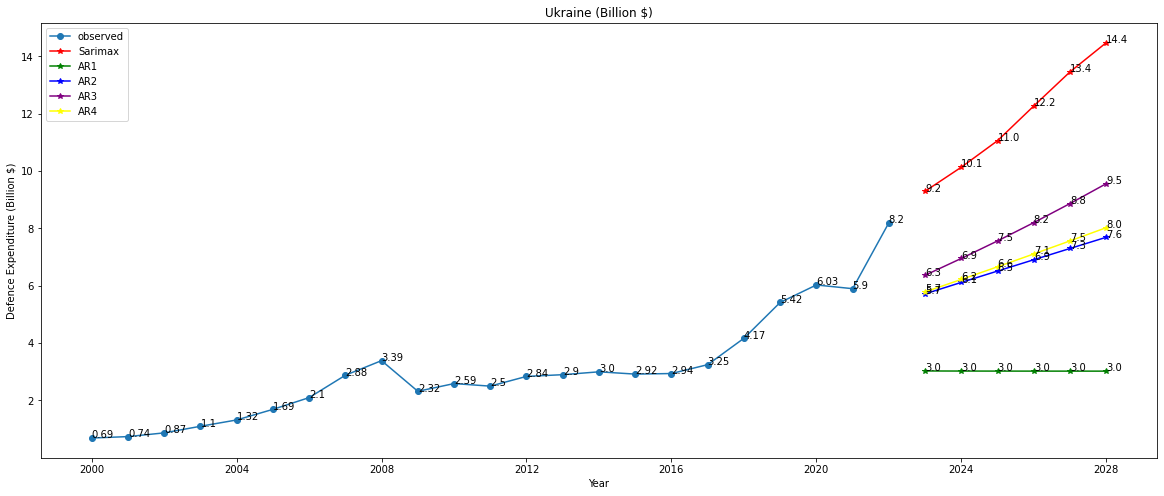

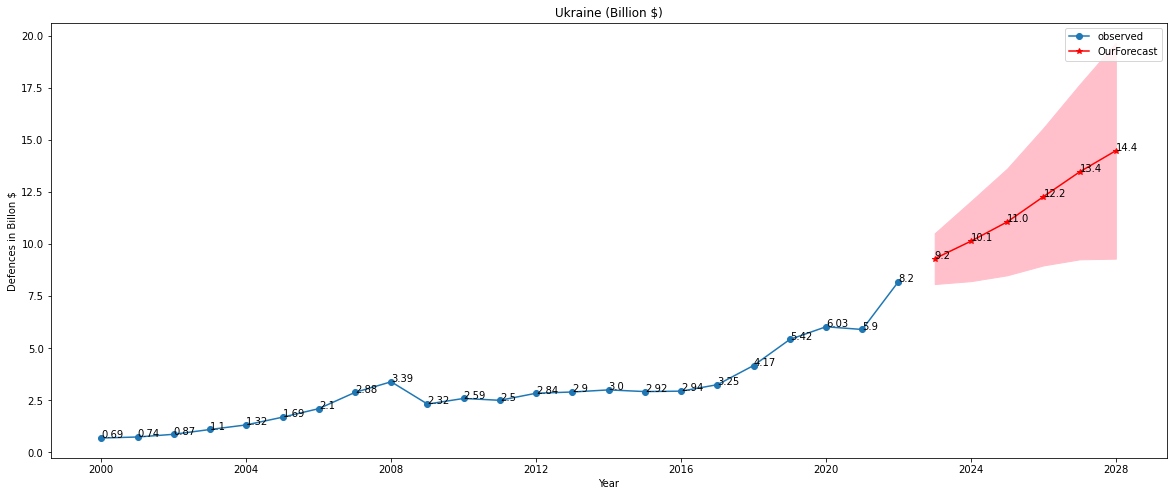





Forecasting the inflation for country:  Russia
########################################
SARIMAX model MSE Score:  7.25
AR1 model MSE Score:  0.0
AR2 model MSE Score:  150.0
AR3 model MSE Score:  3.96
AR4 model MSE Score:  3.75
AR5 model MSE Score:  1.21
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,66.917068,69.696324,67.176672,72.617026,83.292810,66.222173
2019-01-01,66.922891,73.124927,68.154355,71.603489,78.108255,60.976657
2020-01-01,66.927689,76.426280,69.059590,73.394053,83.767549,64.430780
2021-01-01,66.931642,79.484338,69.793140,71.413148,68.338130,61.075629
2022-01-01,66.934898,82.296719,70.384309,71.770487,76.126965,65.222556
2023-01-01,66.937581,84.879608,70.863638,70.650335,67.617690,69.280409
2024-01-01,66.939792,87.251107,71.253192,71.121933,83.285144,68.568215
2025-01-01,66.941613,89.428406,71.569900,70.725136,72.921767,67.863342
2026-01-01,66.943113,91.427388,71.827379,71.088172,84.381260,67.165715


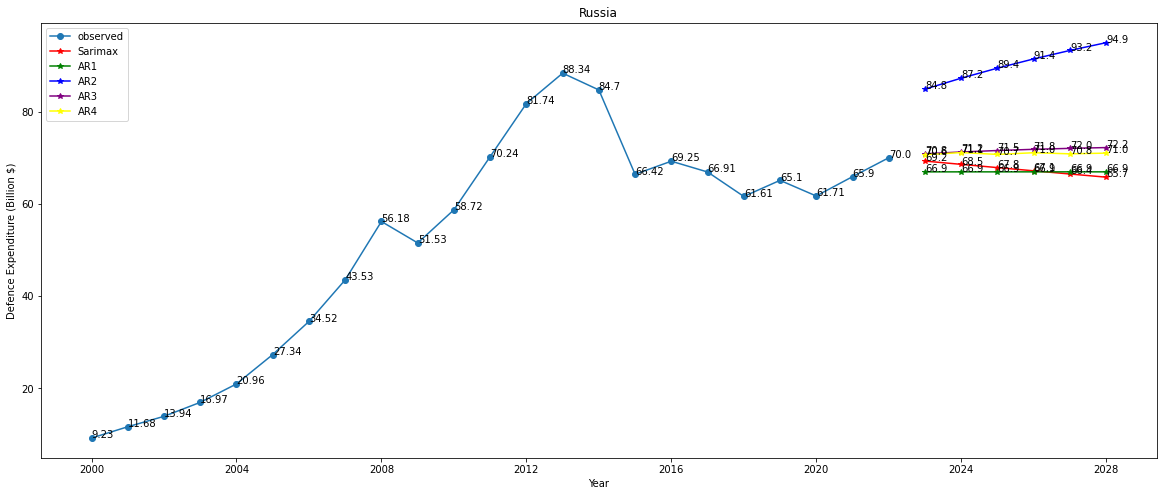

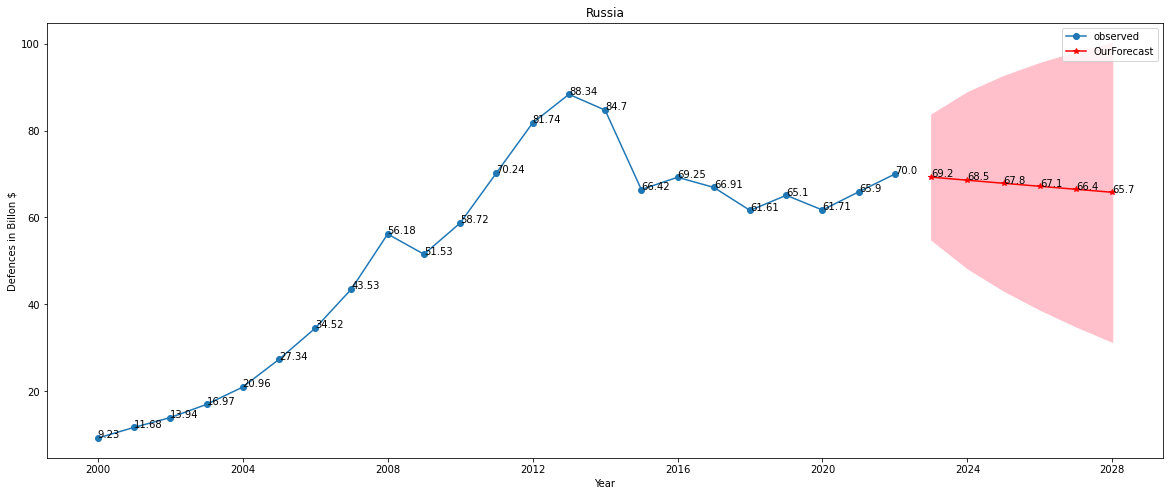

In [82]:
data = pd.read_excel("depenses updated.xlsx")
data.index = data["Year"].apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y'))
data = data.drop(["Year"], axis =1)
data_to_focus = data[["Ukraine (Billion $)","Russia"]]

forecast_n_plot(data_to_focus, "Defence Expenditure (Billion $)")





Forecasting the inflation for country:  Ukraine import
########################################
SARIMAX model MSE Score:  30.43
AR1 model MSE Score:  1669.54
AR2 model MSE Score:  160.94
AR3 model MSE Score:  8887.89
AR4 model MSE Score:  15956.38
AR5 model MSE Score:  63.41
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,11.219927,44.464756,-0.474492,69.977460,33.782176,6.616755
2019-01-01,23.460284,33.624345,-2.399354,90.503330,50.956071,32.953184
2020-01-01,44.212061,24.820528,-3.860961,87.299316,28.515686,30.072506
2021-01-01,79.393738,30.399851,-4.740091,30.062424,22.774041,25.075945
2022-01-01,139.039252,31.429248,-5.316468,27.237402,52.130401,27.113204
2023-01-01,240.159708,29.521004,-5.681958,34.644951,66.973774,50.232834
2024-01-01,411.595011,29.746126,-5.916682,83.379018,41.248876,50.232834
2025-01-01,702.239104,30.240001,-6.066695,72.884221,32.543181,50.232834
2026-01-01,1194.984687,30.038568,-6.162747,65.844913,62.524056,50.232834


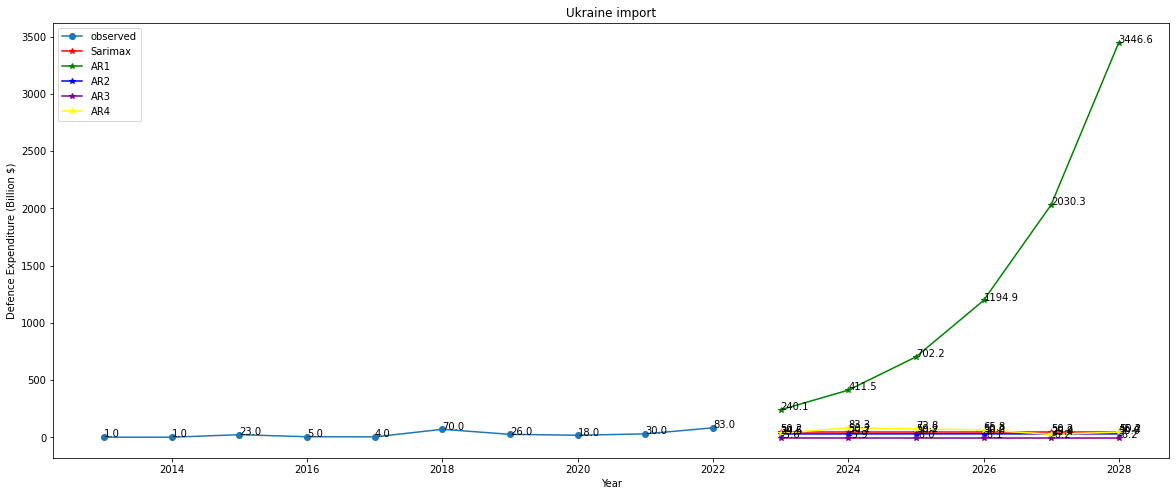

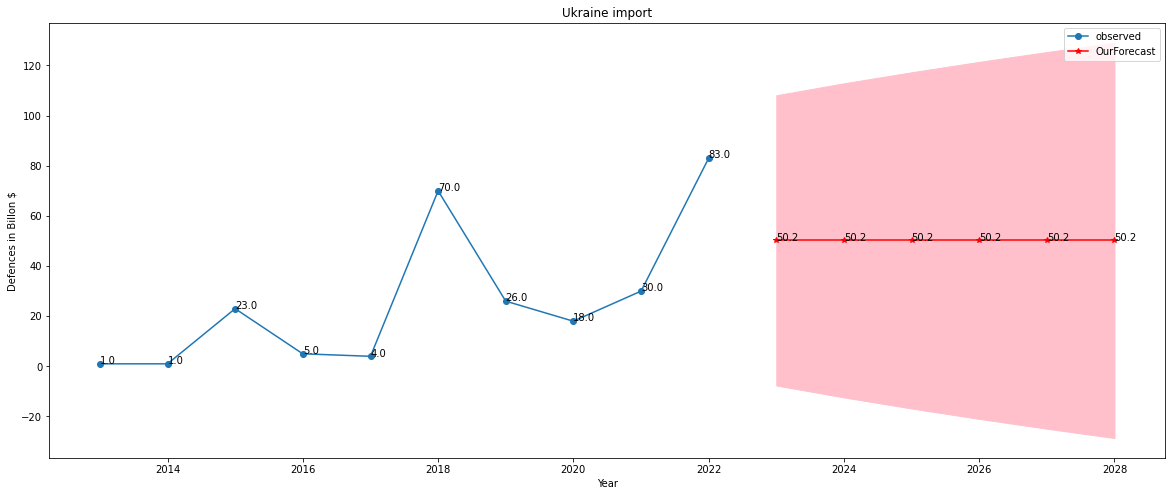





Forecasting the inflation for country:  Ukraine Export(Billion $)
########################################
SARIMAX model MSE Score:  252.67
AR1 model MSE Score:  9961.87
AR2 model MSE Score:  71976.42
AR3 model MSE Score:  482313.37
AR4 model MSE Score:  67393.46
AR5 model MSE Score:  243052.43
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,352.134896,441.712834,420.551943,381.169007,588.158220,389.048268
2019-01-01,383.851428,428.288935,423.183285,310.919650,545.106398,210.719466
2020-01-01,406.138804,464.465049,513.334225,348.167169,546.865814,163.507062
2021-01-01,421.800262,471.276163,570.986145,312.207078,544.657522,139.722235
2022-01-01,432.805652,484.105161,659.397140,328.411609,402.688234,114.964638
2023-01-01,440.539198,489.972772,742.678427,311.626624,556.126493,45.599779
2024-01-01,445.973602,495.554413,841.066103,319.680698,492.737053,46.496963
2025-01-01,449.792386,498.973728,944.118377,311.829644,611.019294,55.253893
2026-01-01,452.475867,501.661236,1058.675302,315.569152,576.841125,45.028458


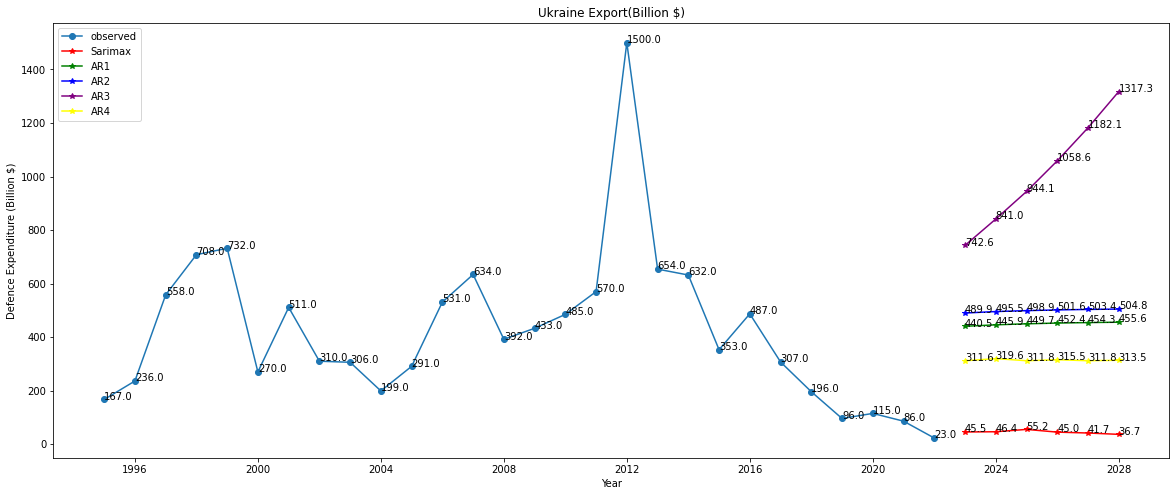

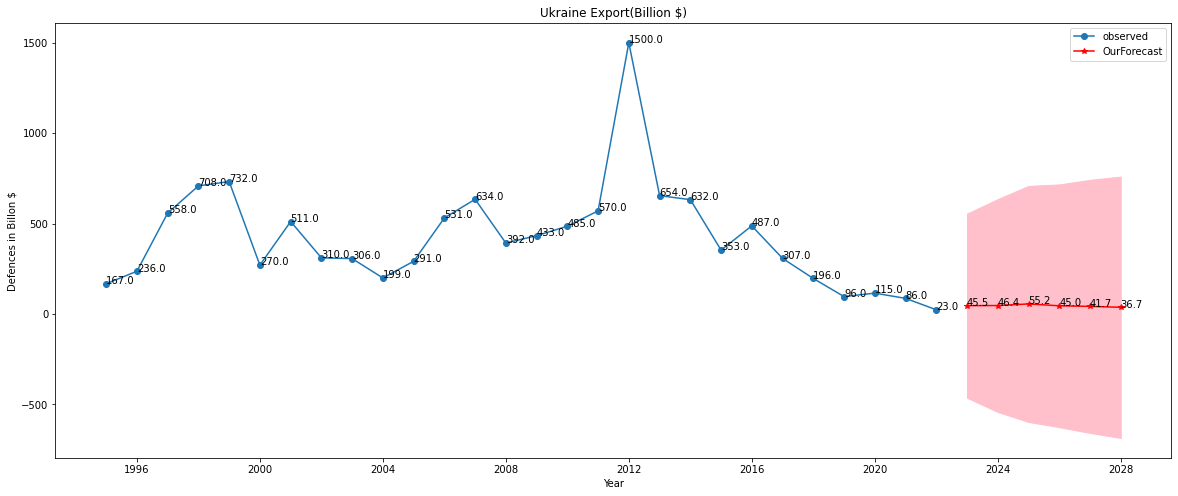





Forecasting the inflation for country:  Russia import
########################################
SARIMAX model MSE Score:  34.83
AR1 model MSE Score:  10697.55
AR2 model MSE Score:  16647.46
AR3 model MSE Score:  191.54
AR4 model MSE Score:  5.46
AR5 model MSE Score:  7783.61
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,123.004880,46.161602,108.237796,73.993773,72.620722,73.230016
2019-01-01,126.857175,36.800504,111.185144,37.513408,7.338330,20.472908
2020-01-01,127.351768,59.417160,106.754113,92.087306,87.605403,15.748391
2021-01-01,127.415268,87.097490,108.599090,243.510904,35.429986,36.221298
2022-01-01,127.423421,98.081429,108.640190,446.556012,71.946107,70.080338
2023-01-01,127.424467,89.871789,108.312414,447.096650,65.953296,78.741953
2024-01-01,127.424602,74.727149,108.522706,-53.344727,130.855003,62.002951
2025-01-01,127.424619,65.919434,108.513817,-1080.907840,78.768617,48.822335
2026-01-01,127.424621,67.764708,108.499246,-1877.809195,126.214231,38.443660


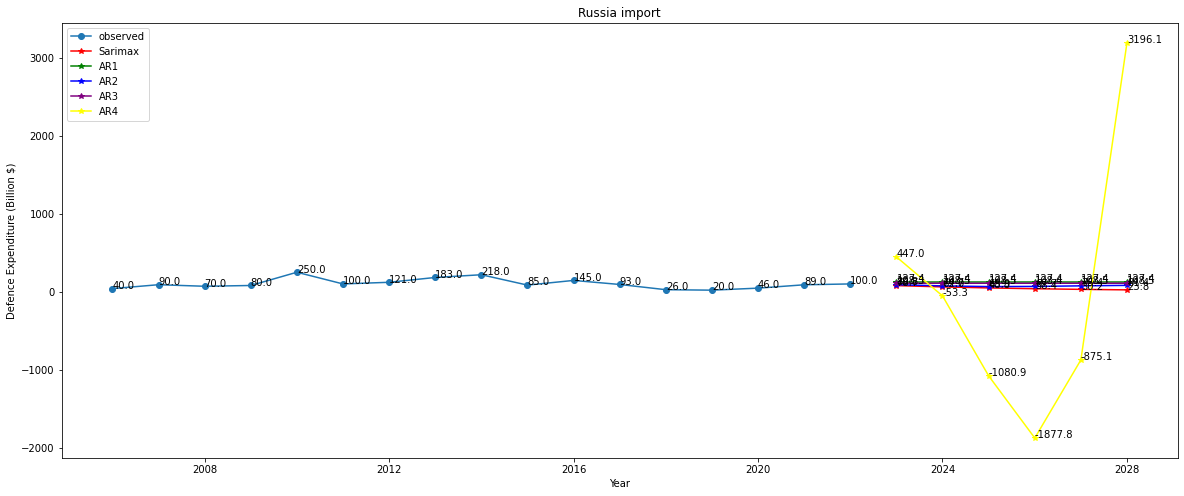

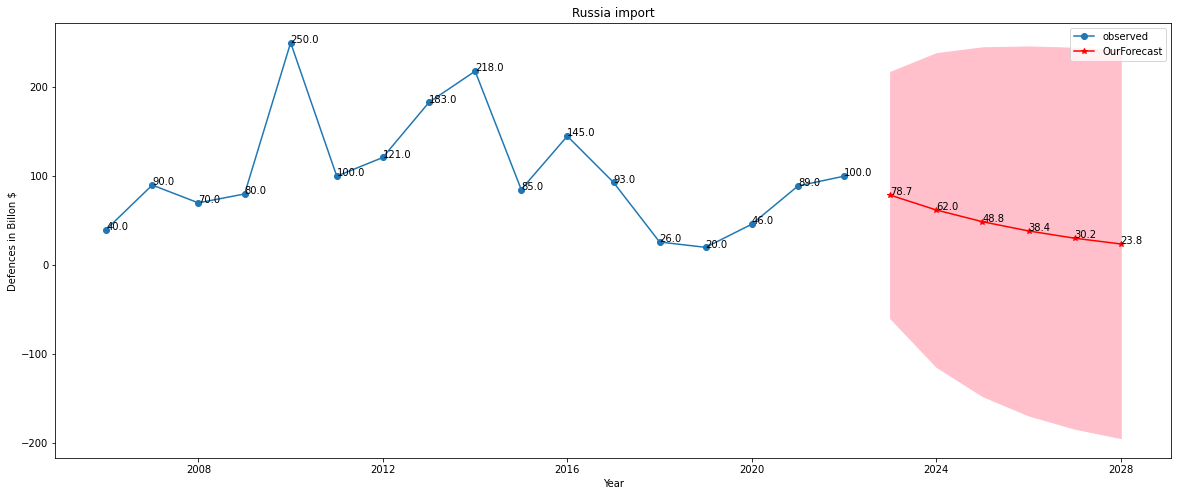





Forecasting the inflation for country:  Russia Export(Billion $)
########################################
SARIMAX model MSE Score:  1.21
AR1 model MSE Score:  10.18
AR2 model MSE Score:  0.8
AR3 model MSE Score:  5.03
AR4 model MSE Score:  0.14
AR5 model MSE Score:  0.22
########################################



TABLE SHOWING DIFFERENT MODELS WITH FORECASTED VALUES



,AR1,AR2,AR3,AR4,AR5,SARIMAX
Date,,,,,,
2018-01-01,6.193283,5.650748,5.563179,5.774791,5.793603,5.879029
2019-01-01,6.271619,5.362316,5.173855,5.655412,5.676066,6.521203
2020-01-01,6.329904,5.172053,4.885045,5.608624,5.629139,5.046617
2021-01-01,6.373270,5.046547,4.670799,5.590381,5.610404,3.093057
2022-01-01,6.405537,4.963757,4.511867,5.583262,5.602924,2.356247
2023-01-01,6.429545,4.909145,4.393967,5.580483,5.599938,1.351945
2024-01-01,6.447408,4.873120,4.306506,5.579399,5.598745,1.305539
2025-01-01,6.460699,4.849357,4.241625,5.578976,5.598269,1.260727
2026-01-01,6.470588,4.833681,4.193495,5.578811,5.598079,1.217452


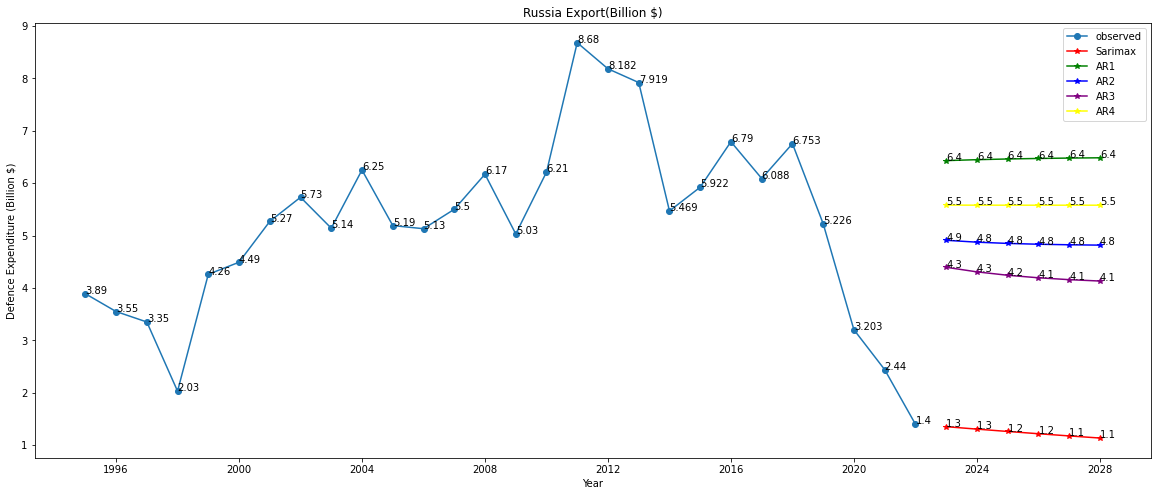

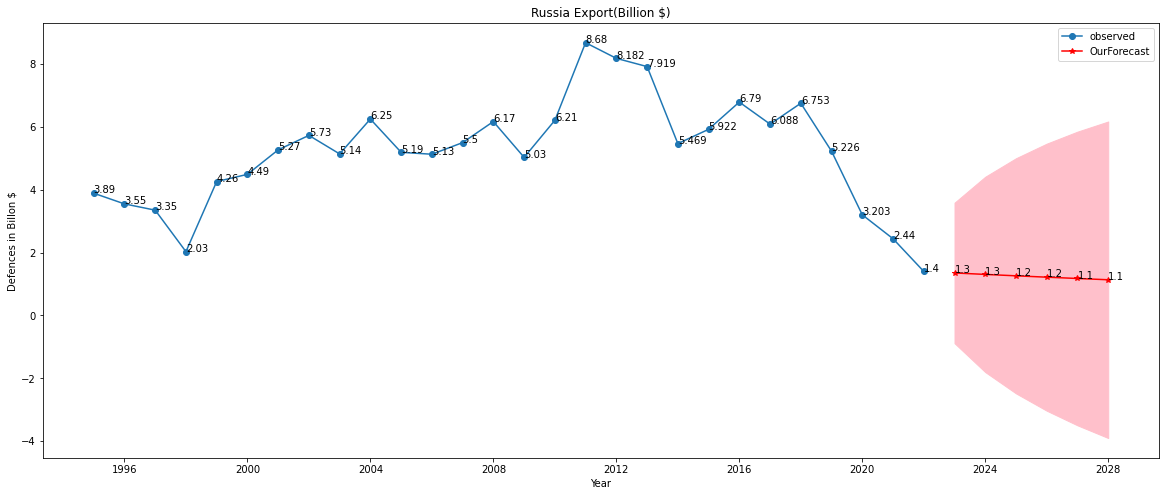

In [83]:
data = pd.read_excel("arms ExpImp updated.xlsx")
data.index = data["Year"].apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y'))
data = data.drop(["Year"], axis =1)
data_to_focus = data[["Ukraine import",	"Ukraine Export(Billion $)",	"Russia import",	"Russia Export(Billion $)"]]

forecast_n_plot(data_to_focus, "Defence Expenditure (Billion $)")